In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# =========================================================
# 1) LOAD DATA + BERSIHKAN (sesuai instruksi TA-10)
# =========================================================
# Pastikan file ini ada di folder kerja notebook kamu
df = pd.read_csv("time-series-19-covid-combined.csv")

# Pilih negara yang akan dianalisis
country = "Indonesia"

# Filter data Indonesia
sub = df[df["Country/Region"] == country].copy()

# Ubah kolom Date jadi datetime
sub["Date"] = pd.to_datetime(sub["Date"])

# Karena dataset per provinsi, kita agregasi total Indonesia per hari
daily = sub.groupby("Date")[["Confirmed", "Recovered", "Deaths"]].sum().reset_index()


In [ ]:
# =========================================================
# 2) BENTUK VARIABEL SIR DARI DATA TIME-SERIES
# =========================================================
# Definisi:
# C(t) = Confirmed kumulatif
# R(t) = Recovered kumulatif
# D(t) = Deaths kumulatif
# I(t) = C - R - D
# R_sir(t) = R + D
daily["I"] = daily["Confirmed"] - daily["Recovered"] - daily["Deaths"]
daily["R_sir"] = daily["Recovered"] + daily["Deaths"]

# Ambil index pertama kali kasus muncul (biar tuning lebih meaningful)
first_case_idx = int(np.argmax(daily["Confirmed"].values > 0))

# Potong data mulai dari hari pertama ada kasus
daily = daily.iloc[first_case_idx:].reset_index(drop=True)

# Waktu t (hari sejak first_case_idx)
t_data = np.arange(len(daily), dtype=float)

# Total populasi Indonesia (boleh kamu ubah jika ingin)
N = 270e6

# Normalisasi (tips modul TA-10 supaya stabil dan tidak overflow)
I_data = daily["I"].values / N
R_data = daily["R_sir"].values / N
S_data = 1 - I_data - R_data

In [ ]:
# =========================================================
# 3) DEFINISI MODEL ODE SIR (sesuai contoh modul)
# =========================================================
def sir_model(t, Y, beta, gamma):
    S, I, R = Y
    dSdt = -beta * S * I
    dIdt =  beta * S * I - gamma * I
    dRdt =  gamma * I
    return np.array([dSdt, dIdt, dRdt])

# =========================================================
# 4) RK4 SOLVER MANUAL (DILARANG scipy.integrate)
# =========================================================
def rk4_solver(f, t_span, y0, h, params):
    t0, tf = t_span
    t_vals = np.arange(t0, tf + h, h)
    y_vals = np.zeros((len(t_vals), len(y0)))
    y_vals[0] = y0

    for i in range(len(t_vals) - 1):
        t_n = t_vals[i]
        y_n = y_vals[i]

        k1 = f(t_n, y_n, *params)
        k2 = f(t_n + h/2, y_n + h*k1/2, *params)
        k3 = f(t_n + h/2, y_n + h*k2/2, *params)
        k4 = f(t_n + h,   y_n + h*k3,   *params)

        y_vals[i+1] = y_n + (h/6)*(k1 + 2*k2 + 2*k3 + k4)

    return t_vals, y_vals

In [9]:
# =========================================================
# 5) PARAMETER TUNING (grid search sederhana) - versi diperbaiki
# =========================================================
def rmse(a, b):
    return math.sqrt(np.mean((a - b)**2))

# Rentang tebakan parameter (biarkan dulu sama seperti punyamu)
beta_range  = np.linspace(0.05, 1.5, 40)
gamma_range = np.linspace(0.01, 0.6, 40)

best_params = None
best_err = np.inf

h = 1.0  # step RK4 = 1 hari (sesuai resolusi data harian)

for beta in beta_range:
    for gamma in gamma_range:
        params = (beta, gamma)

        t_sim, Y_sim = rk4_solver(
            sir_model,
            (0, len(t_data)-1),  # rapih dari 0 sampai akhir data
            y0=[S_data[0], I_data[0], R_data[0]],
            h=h,
            params=params
        )

        # Tolak solusi yang tidak masuk akal secara fisik
        if np.any(Y_sim < 0) or np.any(Y_sim > 1.0):
            continue

        # Interpolasi agar panjangnya sama dengan data time-series
        I_sim_tmp = np.interp(t_data, t_sim, Y_sim[:, 1])
        R_sim_tmp = np.interp(t_data, t_sim, Y_sim[:, 2])

        # Error gabungan (fokus utama I, tapi tetap perhatikan R)
        err_I = rmse(I_data, I_sim_tmp)
        err_R = rmse(R_data, R_sim_tmp)
        err = 0.7 * err_I + 0.3 * err_R

        if err < best_err:
            best_err = err
            best_params = params

print("Parameter terbaik:")
print("beta =", best_params[0])
print("gamma =", best_params[1])
print("RMSE terbaik =", best_err)

# =========================================================
# 6) SIMULASI FINAL dengan parameter terbaik
# =========================================================
t_sim, Y_sim = rk4_solver(
    sir_model,
    (0, len(t_data)-1),
    y0=[S_data[0], I_data[0], R_data[0]],
    h=h,
    params=best_params
)

S_sim = np.interp(t_data, t_sim, Y_sim[:, 0])
I_sim = np.interp(t_data, t_sim, Y_sim[:, 1])
R_sim = np.interp(t_data, t_sim, Y_sim[:, 2])


Parameter terbaik:
beta = 0.2358974358974359
gamma = 0.19153846153846155
RMSE terbaik = 0.00013721731175005104


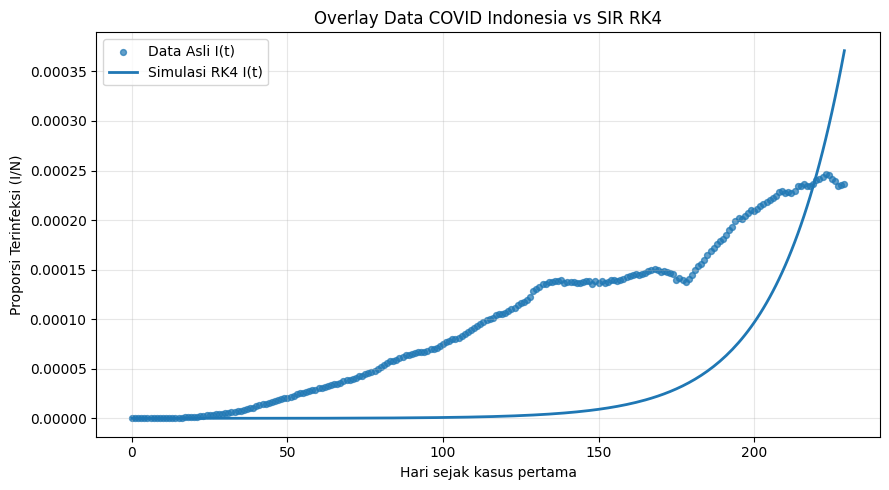

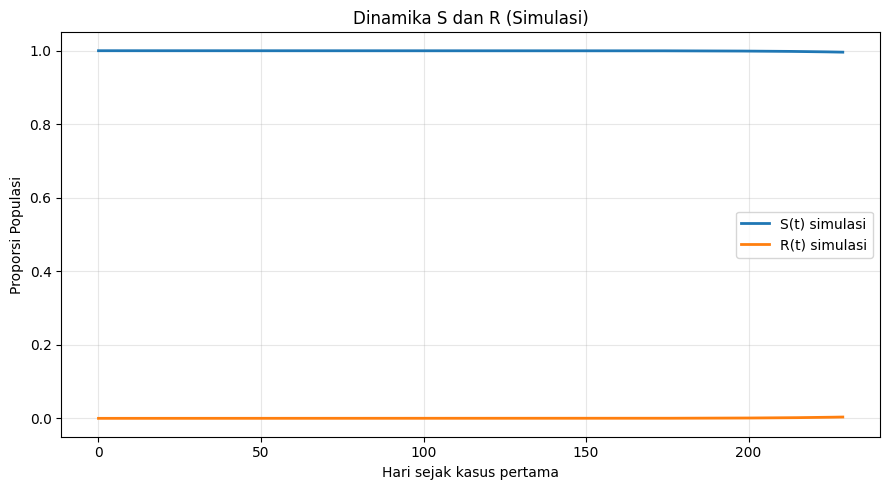

In [7]:
# =========================================================
# 7) OVERLAY PLOT (sesuai instruksi TA-10) - versi diperbaiki
# =========================================================
plt.figure(figsize=(9,5))
plt.scatter(t_data, I_data, label="Data Asli I(t)", s=18, alpha=0.7)
plt.plot(t_data, I_sim, label="Simulasi RK4 I(t)", linewidth=2)

plt.xlabel("Hari sejak kasus pertama")
plt.ylabel("Proporsi Terinfeksi (I/N)")
plt.title("Overlay Data COVID Indonesia vs SIR RK4")

plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# Plot S dan R (Opsional) - versi diperbaiki
# =========================================================
plt.figure(figsize=(9,5))
plt.plot(t_data, S_sim, label="S(t) simulasi", linewidth=2)
plt.plot(t_data, R_sim, label="R(t) simulasi", linewidth=2)

plt.xlabel("Hari sejak kasus pertama")
plt.ylabel("Proporsi Populasi")
plt.title("Dinamika S dan R (Simulasi)")

plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
